In [12]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image

IMG_SIZE = 512, 512
MAX_PIXEL_VALUE = 255
CKPT_PATH = Path("../runs/basic_autoencoder_10imgs/best_checkpoint.pth")
DEVICE = "cpu"

In [13]:
def get_psnr(original: np.ndarray, compressed: np.ndarray):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = np.mean((original - compressed)**2)
    return 10 * np.log10(MAX_PIXEL_VALUE**2/mse)


def get_bpp(filepath: Path):
    """Calculate Bytes Per Pixel"""
    return 8 * filepath.stat().st_size / np.prod(IMG_SIZE)

# Compress assets

In [14]:
# import sys
# sys.path.append("../")

In [15]:
# from main import encode, decode

In [16]:
assets_dir = Path("../assets")
images_dir = assets_dir / "images"
compressed_dir = assets_dir / "compressed"
decompressed_dir = assets_dir / "decompressed"

# for img_p in tqdm(list(images_dir.iterdir())[:1]):
#     for b in [2, 8]:
#         # compress
#         compressed_path = compressed_dir / f"b={b}" / img_p.name.replace(".png", ".npz")
#         compressed_path.parent.mkdir(parents=True, exist_ok=True)
#         encode(CKPT_PATH, img_p, compressed_path, b, DEVICE)

#         # decompress
#         decompressed_path = decompressed_dir / f"b={b}" / img_p.name
#         decompressed_path.parent.mkdir(parents=True, exist_ok=True)
#         decode(CKPT_PATH, compressed_path, decompressed_path, b, DEVICE)


# Map JPG with compressed qualities 

In [48]:
from collections import defaultdict

res = defaultdict(dict)


def find(img, target_bpp):
    tmp = "tmp.jpg"
    img = img.copy()
    l, r = 1, 100
    while l < r:
        q = (l + r) // 2
        cv2.imwrite(tmp, img, [cv2.IMWRITE_JPEG_QUALITY, q])
        cur_bpp = get_bpp(Path(tmp))
        if cur_bpp >= target_bpp:
            r = q
        else: 
            l = q + 1
    os.remove(tmp)
    return l
        

for img_p in images_dir.iterdir():
    for b in ["b=2", "b=8"]:
        compressed_path = compressed_dir / b / img_p.name.replace(".png", ".npz")
        compressed_bpp = get_bpp(compressed_path)
        img = cv2.imread(img_p.as_posix())[..., ::-1]
        jpg_q = find(img, compressed_bpp)
        res[b][img_p.name] = jpg_q

res

defaultdict(dict,
            {'b=2': {'baboon.png': 42, 'lena.png': 76, 'peppers.png': 71},
             'b=8': {'baboon.png': 99, 'lena.png': 100, 'peppers.png': 100}})

In [49]:
jpg_dir = assets_dir / "jpg"

for b in res:
    for img_name in res[b]:
        orig_path = images_dir / img_name
        jpg_path = jpg_dir / b / img_name.replace(".png", ".jpg")
        jpg_path.parent.mkdir(parents=True, exist_ok=True)
        img = cv2.imread(orig_path.as_posix())
        cv2.imwrite(jpg_path.as_posix(), img, [cv2.IMWRITE_JPEG_QUALITY, res[b][img_name]])

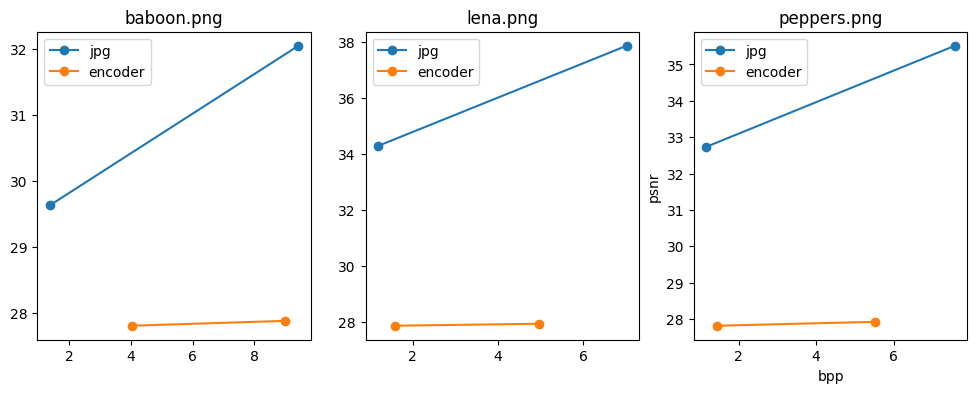

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plt.xlabel("bpp")
plt.ylabel("psnr")

for i, img_p in enumerate(images_dir.iterdir()):
    orig_img = cv2.imread(img_p.as_posix())[..., ::-1]

    metrics = {
        "psnr": {"jpg": [], "encoder": []},
        "bpp": {"jpg": [], "encoder": []},
    }

    for b in [2, 8]:
        jpg_img_path = jpg_dir / f"b={b}" / img_p.name.replace(".png", ".jpg")
        encoder_img_path = decompressed_dir / f"b={b}" / img_p.name

        jpg_img = cv2.imread(jpg_img_path.as_posix())[..., ::-1]
        encoder_img = cv2.imread(encoder_img_path.as_posix())[..., ::-1]

        metrics["bpp"]["jpg"] += [get_bpp(jpg_img_path)]
        metrics["bpp"]["encoder"] += [get_bpp(encoder_img_path)]
        metrics["psnr"]["jpg"] += [get_psnr(orig_img, jpg_img)]
        metrics["psnr"]["encoder"] += [get_psnr(orig_img, encoder_img)]

    ax = axs[i]
    ax.set_title(img_p.name)
    ax.plot(metrics["bpp"]["jpg"], metrics["psnr"]["jpg"], "-o", label="jpg")
    ax.plot(metrics["bpp"]["encoder"], metrics["psnr"]["encoder"], "-o", label="encoder")
    ax.legend()

In [37]:
plt.savefig("../assets/results.png")

<Figure size 640x480 with 0 Axes>